In [147]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from itertools import islice
from tqdm import tqdm

wandb.login()

wandb_entity = os.environ.get('WANDB_ENTITY')
api.flush()
all_runs = api.runs(f'{wandb_entity}/deep-rl-banana', per_page=100)
histories = []
for i, run in enumerate(tqdm(all_runs)):
    history = run.history(samples=1000)  # necessary or wandb will randomly sample
    history['DOUBLE_DQN'] = run.config['DOUBLE_DQN']
    history = history[['_step', 'scores', 'DOUBLE_DQN']]
    history['run'] = run.id
    histories.append(history)

combined = pd.concat(histories)
combined = combined[combined._step < 1000]
double_dqn = combined[combined.DOUBLE_DQN].reset_index()
dqn = combined[~combined.DOUBLE_DQN].reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


# Introduction

This project implements a deep reinforcement learning algorithm to solve a problem involving navigating a square world where the goal is to gather yellow bananas and avoid purple bananas.  The state is represented as a continuous space of 37 variables, while the possible actions form a discrete space of 4 possible actions (forward, backward, left, right).  The problem is considered solved when the algorithm manages to average a score over 13 for a period of 100 episodes.

# The Problem

## Reinforcement Learning

The general idea behind reinforcement learning is this:

* problem can be represented as a sequence of states, actions, and rewards ${s_0, a_0, r_1, s_1, a_1, \ldots, s_n, a_n, r_n}$
* a solution to a problem can be represented as a mapping of states $s\in S$ to actions $a\in A$, where each action results in a reward $r\in R$ and a subsequent state $s'\in S$
* the best action(s) can be selected by estimating the expected long term reward received by performing a given action in a given state.
* the long term reward can be shaped by applying a discount factor $\lambda$ (in this implementation, 0.99) to encourage getting rewards sooner rather than later

These ideas can be combined into a family of equations collectively referred to as Bellman equations, for example this one which expresses it in terms of states and actions:

$$Q(s,a) = E\left[ \sum_{t=0}^\infty \lambda^t R_{t+n} |S=s_n, A=a_n\right]$$

## Q Learning

The main idea of Q learning is that if we can estimate the best possible average reward that can be gained from the state that follows our current state after performing a given action, we can use that estimate as a substitute for the rest of the infinite sum, which lets us use this equation instead.

$$Q(s, a)=E\left[R_t + \lambda \text{max} Q_b(S_{t+1}, b) | S_t=s, A_t=a \right]$$

To converge on this value, we randomly initialize an estimate of $Q(s, a)$ for all $s\in S, a\in A$, then sample the environment repeatedly to get tuples of (state, action, reward, next_state) and update our estimate of the value $Q(s, a)$ using this iterative algorithm. where $\alpha$ represents the degree to which we shift our estimate towards the immediately perceived combination of immediate reward and estimated future reward:

$$Q(s, a)=Q(s, a) + \alpha\left[r + \lambda \text{max}_{b} Q(s', b) - Q(s, a)\right]$$

this inner expression is frequently extracted and referred to as the TD-error:

$$\delta = r + \lambda \text{max}_{b} Q(s', b) - Q(s, a)$$

In order to focus in on the best strategies in a large state space, we begin by exploring random choices and gradually adjust our behaviour to exploit the best known actions.  This is done by employing a strategy called $\epsilon$-greedy, where $\epsilon$ represents the percentage of time that a random action is selected, while $1-\epsilon$ is the chance that we will exploit the best estimated action.  For this solution, we start with $\epsilon=1$ and decay at a rate of $0.995$ per episode down to a minimum of $\epsilon=0.1$.

For relatively small state/action spaces, it's possible to represent them as a simple matrix of $S \times A$.  This is commonly referred to as tabular Q learning.

As the size of the state space can exceed the capacity of computers to store the entire space in its exact form, function approximation is used to calculate a representation.  Instead of storing the Q values in a matrix, instead a function $Q(s, a|\theta)$ is learned, where $\theta$ generally represents an array of weights which are learned using gradient descent.

In the gradient descent process, the $\alpha$ from the tabular system is essentially equivalent to the learning rate in the gradient descent optimizer.

## Deep Q Learning

This project is primarily based on DeepMind's original Deep Q Learning paper:

https://arxiv.org/abs/1312.5602

Moving to an estimated value function instead of tabular storage introduces stability issues.  Deep Q Learning's two primary insights are experience replay and fixed Q targets.

## Experience Replay

With experience replay, the agent gathers tuples (experiences) of $(s, a, r, s')$ and stores them in a fixed length FIFO queue (in this implementation, up to 100000 experiences).  Periodically (in this implementation, every 4 actions), the agent samples a subset of experiences from this buffer (in this implentation, a batch size of 64 experiences) and applies the iterative update algorithm described above to move the estimator closer to an optimal strategy.  This solves two main issues:

First of all, the cost of gathering samples can be prohibitive.  By reusing samples several times, we extract more value from each individual experience.  In this algorithm, a sample is reused on average 8 times.

Second, a sequence of actions that are experienced by an agent are likely to be highly correlated, which if used in the order they are found will result in heavily biased learning that can focus in on a certain part of the state/action space and cause catastrophic forgetting of lessons learned from distantly prior experiences.  By introducing an element of random selection in the batch selection, this produces less correlated training data and correspondingly better learning.

## Fixed Q Targets

In the case of tabular Q learning, it's possible to update individual Q values independently without affecting any other elements in the matrix.  When using function approximation, by adjusting the weight values of our estimate $Q(s, a|\theta)$, the estimate of the Q values for all other $(s, a)$ change.  What the original DQN algorithm proposes is holding a separate copy of the weight $\theta'$ to be used during the iterative update algorithm which updates the "live" weights $\theta$, and periodically replacing $\theta'$ with the most recent $\theta$.  This has been empirically shown to improve learning stability.

# Enhancements

Beyond the original paper, I consider two improvements to the algorithm.

## Soft updates

Lillicrap et al proposed the method of soft updates.

https://arxiv.org/pdf/1509.02971.pdf

Instead of holding out the target network weights $\theta'$ for an extended period of time before copying over the live network $\theta$, instead after every iterative update we interpolate a fraction $\tau=0.001$ of the live weights into $\theta'$.

## Double DQN

Adapting classic Double Q learning to the context of Deep RL was demonstrated in:

https://arxiv.org/abs/1509.06461

The classic idea of double Q learning is that a model's estimate of Q value can result in blindly following an overestimation.  Instead of calculating $\text{max}_a Q(s, a)$ the original idea is to maintain and train two separate models, $Q_1$ and $Q_2$.  Then in the iterative update process, instead of

$$Q_1(s, a)=Q_1(s, a) + \alpha\left[r + \text{max}_b Q_1(s', b)\right]$$

instead choose randomly between the two networks and select one as $Q_1$ and the other as $Q_2$:

$$Q_1(s, a)=Q_1(s, a) + \alpha\left[r + Q_1\left(s', \text{argmax}_b Q_2(s', b)\right)\right]$$

The idea being that if Q_1 is overestimating a value, our value estimate will be regularized by choosing the best action index using model Q_2 to select an estimate from Q_1.

The adaptation in the context of Deep RL is that we already have a second network available to us in $\theta'$, or the target network.  In other words, we now make our iterative update by calculating the TD-error as:

$$\delta = r + Q(s', argmax_b Q(s, b, \theta'), theta) - Q(s, a, \theta)$$

# Hyperparameters

*    n_episodes (int): number of training episodes
*    max_t (int): maximum number of timesteps per episode
*    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
*    eps_end (float): minimum value of epsilon
*    eps_decay (float): decay rate of epsilon per episode
*    double_dqn (bool): whether to use Double DQN
*    buffer_size (int): maximum size of the replay buffer
*    batch_size (int): mini batch size
*    tau (float): the rate of copying the live network weights into the target network
*    lr (float): learning rate for optimizer
*    gamma (float): discount factor for transfering future rewards back down the chain, normally denoted $\lambda$
*    learn_every (int): how often to apply the iterative update algorithm


# Model architecture

The model is a straightforward fully connected neural network consisting of two hidden layers of width 512 and ReLU activations.

    nn.Sequential(
        nn.Linear(37, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
    )

# Results

I averaged a variant of Double DQN versus regular DQN over 50 runs on each setting and found the following result.  On average, Double DQN reached the solution of an average performance of 13 averaged over 100 episodes at steps 478-578, while regular DQN solved it slightly later at steps 571-671.  On average, Double DQN outperforms regular DQN consistently throughout the training process as can be seen by the clear separation in the graph below although there is some variability in individual runs.

The error band in the graph below is the standard deviation.

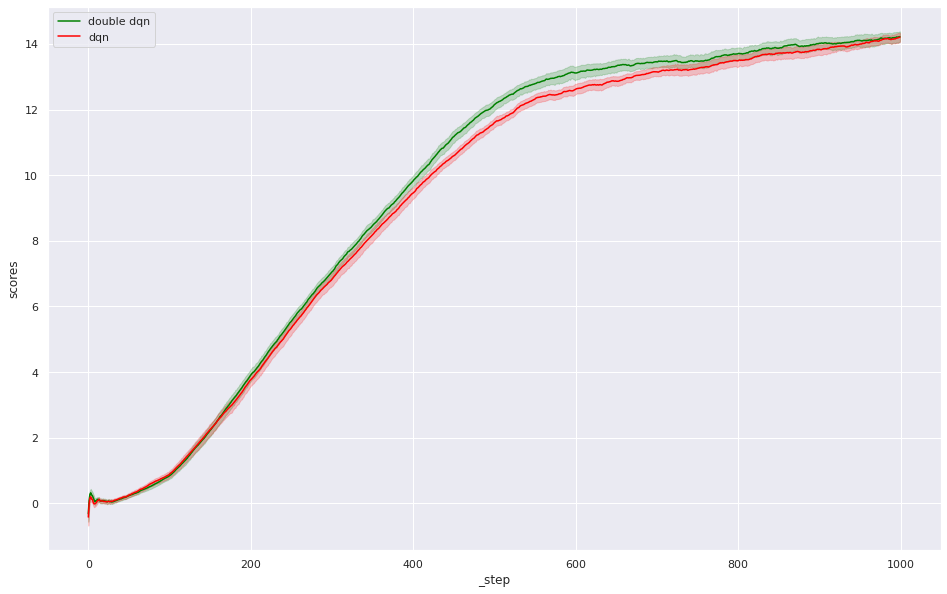

In [148]:
sns.set(rc={'figure.figsize': (16, 10)})
sns.set_theme(style='darkgrid')
sns.lineplot(data=double_dqn, x='_step', y='scores', color='green')
sns.lineplot(data=dqn, x='_step', y='scores', color='red')
plt.legend(labels=[
    'double dqn',
    'dqn',
])

In [149]:
combined.groupby(['_step', 'DOUBLE_DQN']).mean().query('scores >= 13').reset_index().groupby('DOUBLE_DQN').min()[['_step']] - 100

,_step
DOUBLE_DQN,
False,571
True,478


In [ ]:
sns.lineplot(data=double_dqn, x='_step', y='scores', color='green')
sns.lineplot(data=dqn, x='_step', y='scores', color='red')
plt.legend(labels=[
    'double dqn score',
    'dqn score',
])

# Ideas for Future Work

## Hyperparameter Tuning

The most likely target for easy gains is hyperparameter tuning.  The first approach would probably be applying sklearn.model_selection.RandomizedSearchCV or RayTune and just letting it figure something out.

## Prioritized Experience Replay

Prioritized Experience Replay uses the estimated difference between the current network's model and the targets to focus the replay buffer on areas of greatest potential improvement.

## t-Soft Update of Target Network

https://arxiv.org/abs/2008.10861

Instead of using fixed $\tau$ update rates when updating the target network, t-soft updates use a more complex method for choosing the rate to update each weight.

## Dueling Deep Q Learning

https://arxiv.org/pdf/1511.06581.pdf

Instead of learning only action values, a dueling architecture learns the state value separately from the action value and then combines the two predictions into a single action value estimate.  It is essentially a form of auxiliary task learning that has had broad success across a range of deep learning tasks such as image classification.

## Noise Networks for Exploration

https://arxiv.org/pdf/1706.10295.pdf